In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os

%matplotlib inline

In [2]:
train_x = torch.rand(10)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

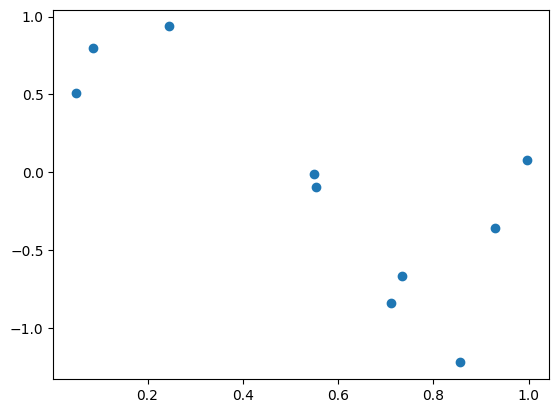

In [3]:
plt.plot(train_x, train_y, 'o')
plt.show()

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.100   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.075   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.050   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 1.024   lengthscale: 0.554   noise: 0.554
Iter 5/50 - Loss: 0.999   lengthscale: 0.513   noise: 0.513
Iter 6/50 - Loss: 0.973   lengthscale: 0.473   noise: 0.474
Iter 7/50 - Loss: 0.948   lengthscale: 0.436   noise: 0.438
Iter 8/50 - Loss: 0.922   lengthscale: 0.401   noise: 0.404
Iter 9/50 - Loss: 0.896   lengthscale: 0.368   noise: 0.372
Iter 10/50 - Loss: 0.871   lengthscale: 0.338   noise: 0.342
Iter 11/50 - Loss: 0.847   lengthscale: 0.309   noise: 0.314
Iter 12/50 - Loss: 0.824   lengthscale: 0.282   noise: 0.289
Iter 13/50 - Loss: 0.803   lengthscale: 0.258   noise: 0.265
Iter 14/50 - Loss: 0.783   lengthscale: 0.236   noise: 0.243
Iter 15/50 - Loss: 0.766   lengthscale: 0.216   noise: 0.222
Iter 16/50 - Loss: 0.751   lengthscale: 0.199   noise: 0.204
Iter 17/50 - Loss: 0.737   length